# Quasar Theory

In [1]:
import pyccl as ccl
import numpy as np
import pylab as plt

from QuasarMapper import QuasarMapper
import pymaster as nmt

Calculate quasar maps

In [2]:
data_path = '/home/zcapjru/PhD/Data/'
input_1 = [data_path+'eBOSS_QSO_clustering_data-NGC-vDR16.fits']
input_2 = [data_path+'eBOSS_QSO_clustering_random-NGC-vDR16.fits']

NGC_maps = QuasarMapper(input_1, input_2)

input_3 = [ data_path+'eBOSS_QSO_clustering_data-SGC-vDR16.fits']
input_4 = [ data_path+'eBOSS_QSO_clustering_random-SGC-vDR16.fits']

SGC_maps = QuasarMapper(input_3, input_4)

0.020098573899626757
0.02010122251654186
0.01792628586352441
0.017927855380248842


Cosmology

In [3]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
b_ngc = 2.37*np.ones(199) 
b_sgc = 2.32 *np.ones(199) 

In [4]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
bands = nmt.NmtBin.from_nside_linear(nside, 30)

Redshift distributions

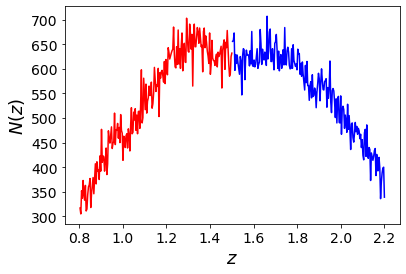

In [5]:
NGC_nz_1 = NGC_maps.get_nz(1)
NGC_nz_2 = NGC_maps.get_nz(2)
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(NGC_nz_1[0], NGC_nz_1[1], 'r-')
plt.plot(NGC_nz_2[0], NGC_nz_2[1], 'b-')
plt.show()

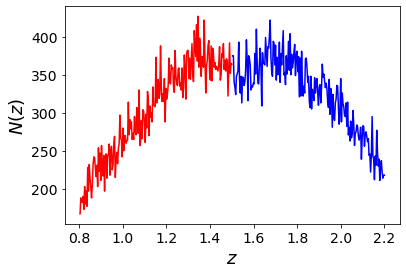

In [6]:
SGC_nz_1 = SGC_maps.get_nz(1)
SGC_nz_2 = SGC_maps.get_nz(2)

plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(SGC_nz_1[0], SGC_nz_1[1], 'r-')
plt.plot(SGC_nz_2[0], SGC_nz_2[1], 'b-')
plt.show()

Theory Predictions

In [7]:
NGC_nz_1 = NGC_maps.get_nz(1)
NGC_z_1 = NGC_nz_1[0]
NGC_dNdz_1 = NGC_nz_1[1]

NGC_nz_2 = NGC_maps.get_nz(2)
NGC_z_2 = NGC_nz_2[0]
NGC_dNdz_2 = NGC_nz_2[1]

In [8]:
SGC_nz_1 = SGC_maps.get_nz(1)
SGC_z_1 = SGC_nz_1[0]
SGC_dNdz_1 = SGC_nz_1[1]

SGC_nz_2 = SGC_maps.get_nz(2)
SGC_z_2 = SGC_nz_2[0]
SGC_dNdz_2 = SGC_nz_2[1]

In [9]:
NGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_1,NGC_dNdz_1), bias=(NGC_z_1,b_ngc))
NGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_2,NGC_dNdz_2), bias=(NGC_z_2,b_ngc))

In [10]:
SGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_1,SGC_dNdz_1), bias=(SGC_z_1,b_sgc))
SGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(SGC_z_2,SGC_dNdz_2), bias=(SGC_z_2,b_sgc))

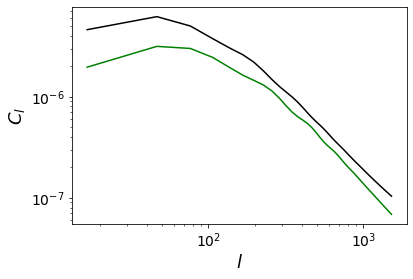

In [11]:
#ell = np.arange(2, 2000)
ell_arr = bands.get_effective_ells()
NGC_theory_11 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar1, ell_arr) 
NGC_theory_12 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar2, ell_arr) 
NGC_theory_22 = ccl.angular_cl(cosmo, NGC_quasar2, NGC_quasar2, ell_arr) 

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell_arr, NGC_theory_11, 'k-')
plt.plot(ell_arr, NGC_theory_12, 'r-')
plt.plot(ell_arr, NGC_theory_22, 'g-')
plt.show()

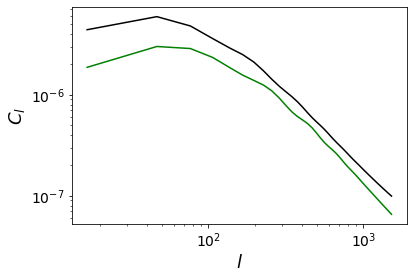

In [12]:
#ell = np.arange(2, 2000)
ell_arr = bands.get_effective_ells()
SGC_theory_11 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar1, ell_arr) 
SGC_theory_12 = ccl.angular_cl(cosmo, SGC_quasar1, SGC_quasar2, ell_arr) 
SGC_theory_22 = ccl.angular_cl(cosmo, SGC_quasar2, SGC_quasar2, ell_arr) 

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell_arr, SGC_theory_11, 'k-')
plt.plot(ell_arr, SGC_theory_12, 'r-')
plt.plot(ell_arr, SGC_theory_22, 'g-')
plt.show()

Process maps into cls 

In [13]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [14]:
# Read healpix maps and initialize a spin-0 and spin-2 field
SGC_delta_1 = SGC_maps.get_delta_map(1)
SGC_delta_2 = SGC_maps.get_delta_map(2)
SGC_mask_1  = SGC_maps.get_mask(1)
SGC_mask_2  = SGC_maps.get_mask(2)

SGC_f_1 = nmt.NmtField(SGC_mask_1, [SGC_delta_1])
SGC_f_2 = nmt.NmtField(SGC_mask_2, [SGC_delta_2])

In [15]:
# Read healpix maps and initialize a spin-0 and spin-2 field
NGC_delta_1 = NGC_maps.get_delta_map(1) 
NGC_delta_2 = NGC_maps.get_delta_map(2) 
NGC_mask_1  = NGC_maps.get_mask(1) 
NGC_mask_2  = NGC_maps.get_mask(2) 

NGC_f_1 = nmt.NmtField(NGC_mask_1, [NGC_delta_1])
NGC_f_2 = nmt.NmtField(NGC_mask_2, [NGC_delta_2])

In [16]:
SGC_w_11 = nmt.NmtWorkspace()
SGC_w_11.compute_coupling_matrix(SGC_f_1, SGC_f_1, bands)

SGC_w_12 = nmt.NmtWorkspace()
SGC_w_12.compute_coupling_matrix(SGC_f_1, SGC_f_2, bands)

SGC_w_22 = nmt.NmtWorkspace()
SGC_w_22.compute_coupling_matrix(SGC_f_2, SGC_f_2, bands)

In [17]:
NGC_w_11 = nmt.NmtWorkspace()
NGC_w_11.compute_coupling_matrix(NGC_f_1, NGC_f_1, bands)

NGC_w_12 = nmt.NmtWorkspace()
NGC_w_12.compute_coupling_matrix(NGC_f_1, NGC_f_2, bands)

NGC_w_22 = nmt.NmtWorkspace()
NGC_w_22.compute_coupling_matrix(NGC_f_2, NGC_f_2, bands)

In [18]:
SGC_empirical_11 = compute_cl(SGC_f_1, SGC_f_1, SGC_w_11)
SGC_empirical_12 = compute_cl(SGC_f_1, SGC_f_2, SGC_w_12)
SGC_empirical_22 = compute_cl(SGC_f_2, SGC_f_2, SGC_w_22)

In [19]:
NGC_empirical_11 = compute_cl(NGC_f_1, NGC_f_1, NGC_w_11)
NGC_empirical_12 = compute_cl(NGC_f_1, NGC_f_2, NGC_w_12)
NGC_empirical_22 = compute_cl(NGC_f_2, NGC_f_2, NGC_w_22)

In [20]:
SGC_nl_11 = SGC_maps.get_nl(1,1)
SGC_nl_22 = SGC_maps.get_nl(2,2)

SGC_alt_nl_11 = SGC_maps.get_alt_nl(1,1)
SGC_alt_nl_22 = SGC_maps.get_alt_nl(2,2)

SGC_nl_11 = SGC_w_11.decouple_cell(SGC_nl_11)
SGC_nl_22 = SGC_w_22.decouple_cell(SGC_nl_22)

SGC_alt_nl_11 = SGC_w_11.decouple_cell(SGC_alt_nl_11)
SGC_alt_nl_22 = SGC_w_22.decouple_cell(SGC_alt_nl_22)

In [21]:
NGC_nl_11 = NGC_maps.get_nl(1,1) 
NGC_nl_22 = NGC_maps.get_nl(2,2) 

NGC_alt_nl_11 = NGC_maps.get_alt_nl(1,1) 
NGC_alt_nl_22 = NGC_maps.get_alt_nl(2,2) 

NGC_nl_11 = NGC_w_11.decouple_cell(NGC_nl_11)
NGC_nl_22 = NGC_w_22.decouple_cell(NGC_nl_22)

NGC_alt_nl_11 = NGC_w_11.decouple_cell(NGC_alt_nl_11)
NGC_alt_nl_22 = NGC_w_22.decouple_cell(NGC_alt_nl_22)
np.savetxt('NGC_nl_11.txt', NGC_nl_11)

In [22]:
SGC_nn_empirical_11 = SGC_empirical_11 - SGC_nl_11
SGC_nn_empirical_alt_11 = SGC_empirical_11 - SGC_alt_nl_11
SGC_nn_empirical_22 = SGC_empirical_22 - SGC_nl_22
SGC_nn_empirical_alt_22 = SGC_empirical_22 - SGC_alt_nl_22

In [23]:
NGC_nn_empirical_11 = NGC_empirical_11 - NGC_nl_11
NGC_nn_empirical_alt_11 = NGC_empirical_11 - NGC_alt_nl_11
NGC_nn_empirical_22 = NGC_empirical_22 - NGC_nl_22
NGC_nn_empirical_alt_22 = NGC_empirical_22 - NGC_alt_nl_22

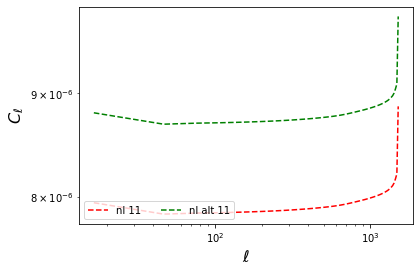

In [24]:
plt.plot(ell_arr, NGC_nl_11[0], 'r--', label='nl 11')
plt.plot(ell_arr, NGC_alt_nl_11[0], 'g--', label='nl alt 11')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

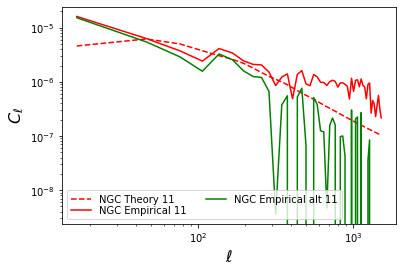

In [25]:
plt.plot(ell_arr, NGC_theory_11, 'r--', label='NGC Theory 11')
plt.plot(ell_arr, NGC_nn_empirical_11[0], 'r-', label='NGC Empirical 11')
plt.plot(ell_arr, NGC_nn_empirical_alt_11[0], 'g-', label='NGC Empirical alt 11')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

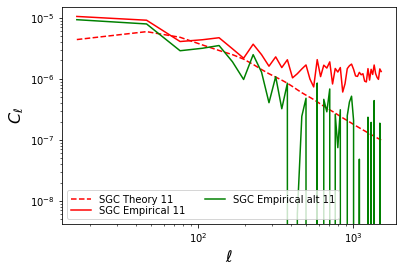

In [26]:
plt.plot(ell_arr, SGC_theory_11, 'r--', label='SGC Theory 11')
plt.plot(ell_arr, SGC_nn_empirical_11[0], 'r-', label='SGC Empirical 11')
plt.plot(ell_arr, SGC_nn_empirical_alt_11[0], 'g-', label='SGC Empirical alt 11')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

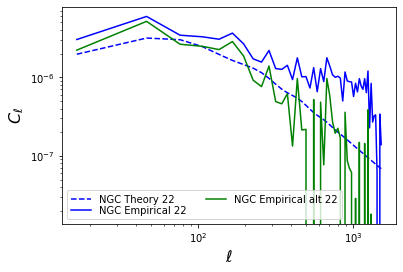

In [27]:
plt.plot(ell_arr, NGC_theory_22, 'b--', label='NGC Theory 22')
plt.plot(ell_arr, NGC_nn_empirical_22[0], 'b-', label='NGC Empirical 22')
plt.plot(ell_arr, NGC_nn_empirical_alt_22[0], 'g-', label='NGC Empirical alt 22')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

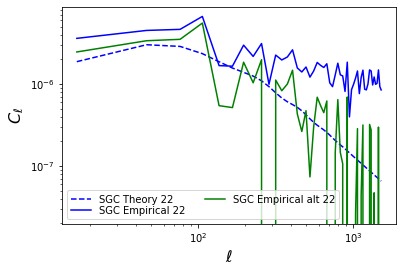

In [28]:
plt.plot(ell_arr, SGC_theory_22, 'b--', label='SGC Theory 22')
plt.plot(ell_arr, SGC_nn_empirical_22[0], 'b-', label='SGC Empirical 22')
plt.plot(ell_arr, SGC_nn_empirical_alt_22[0], 'g-', label='SGC Empirical alt 22')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()